# Uncoupling system of ODE's

In this notebook we illustrate the use of eigenmodes decomposition of a system of linear ordinary differential equations. Such a system is denoted in vector form as $\dot{x}=\mathbf{A}x$ where the matrix $\mathbf{A}$ provides the coupling between variables of vector $x$. For illustration purposes we will study a system of 3 equations, which can be algebrically represented as follows. The key ideas implemented in this notebook are presented in [this video](https://www.youtube.com/watch?v=nyqJJdhReiA&list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m&index=2) by Steve Brunton.

$$
\begin{align}
\dot{x}_{1} &= k_{11}x_{1} + k_{12}x_{2} + k_{13}x_{3}\\
\dot{x}_{2} &= k_{21}x_{1} + k_{22}x_{2} + k_{23}x_{3}\\
\dot{x}_{3} &= k_{31}x_{1} + k_{32}x_{2} + k_{33}x_{3}\\
\end{align}
$$

We start by importing the required tools for numerical integration, linear algebra, and plotting.

In [11]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The coefficients of matrix $\mathbf{A}$ presented below were carefully chosen so that eigenvalues of the problem are negative or null. After reading, you are invited to play with this notebook to produce versions with positive or complex eigenvalues to study their role on system dynamics. For instance, try with the following matrix

```python
A = np.array([[-1.0,  1.0,  0.0],
              [ 1.0, -1.0, -2.0],
              [ 0.0,  2.0, -1.0]])
```

In [12]:
A = np.array([[-1.0,  1.0,  0.0],
              [ 1.0, -1.0,  0.0],
              [ 0.0,  1.0, -1.0]])

The first step to uncouple the system is to retrieve its eigenvalues and eigenvectors. For eigenvectors the matrix `T` returned by `np.linalg.eig` is already in the shape we need. For the eigenvalues we still need to place them on the diagonal of a square matrix, what is easily achieved with `np.diag`.

In [13]:
d, T = np.linalg.eig(A)
D = np.diag(d)

It is important to check the values of eigenvalues once they explain the type of dynamics we will observe in the solution.

In [14]:
d

array([-1.,  0., -2.])

For this sample case we propose to start all variables but the first  to zero.

In [15]:
x0 = np.zeros(A.shape[0])
x0[0] = 1.0

Since the eigenmodes are defined as $x=\mathbf{T}z$, then we can rotate the initial state to eigenspace as $z(0)=\mathbf{T}^{-1}x(0)$, as follows.

In [16]:
z0 = np.linalg.inv(T) @ x0
z0

array([-1.       ,  0.8660254,  0.8660254])

The analytical solution of the problem at `LONG_TIME` is given by $x(t\rightarrow\infty)=\mathbf{T}\exp(\mathbf{D}t)z(0)$. With that we can check the correctness of our implementation.

In [17]:
LONG_TIME = 20.0
T @ (np.exp(np.diag(D) * LONG_TIME) * z0)

array([0.5, 0.5, 0.5])

Next we integrate the problem over a given interval `t_span`. Since the problem in physical or eigen space have different stiffness, the number of required steps by the solver might differ. To be able to compute difference between solutions we provide an additional argument `t_eval` to retrieve the solution over the same time-points.

In [18]:
t_span = (0.0, 10.0)
t_eval = np.linspace(*t_span, 100)
method = "RK45"

sol_physi = solve_ivp(lambda _, x: A @ x, t_span, x0, t_eval=t_eval, method=method)
sol_eigen = solve_ivp(lambda _, z: D @ z, t_span, z0, t_eval=t_eval, method=method)

Since in some cases the solution might be complex, we use `np.real` in what follows to select only the real part (maybe for a given problem you would be interested in the absolute value or multiplication by complex conjugate). Notice that solution in eigen space is converted to physical space through $x=\mathbf{T}z$.

In [19]:
y_physi = np.real(sol_physi.y)
y_eigen = np.real(T @ sol_eigen.y)
y_error = 1000 * np.real(y_eigen - y_physi)

Finally, we plot results and deviation between the two methods of integration.

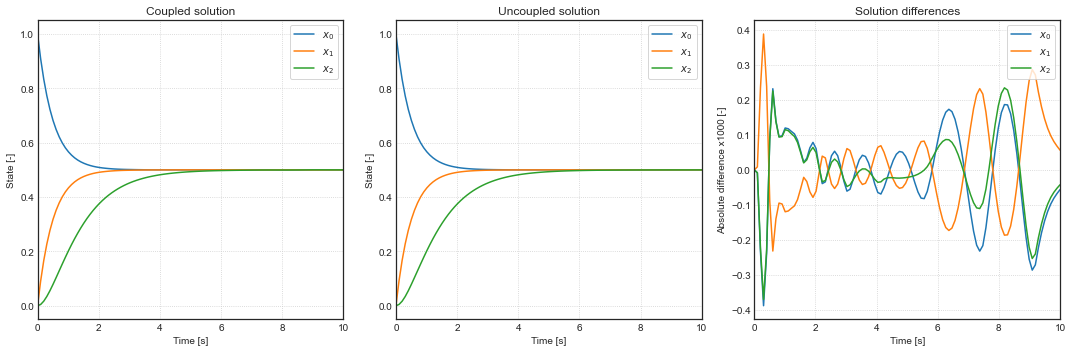

In [20]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(131)
plt.plot(sol_physi.t, y_physi[0], label="$x_{0}$")
plt.plot(sol_physi.t, y_physi[1], label="$x_{1}$")
plt.plot(sol_physi.t, y_physi[2], label="$x_{2}$")
plt.grid(linestyle=":")
plt.title("Coupled solution")
plt.xlabel("Time [s]")
plt.ylabel("State [-]")
plt.legend(loc=1, frameon=True)
plt.xlim(t_span)

ax2 = plt.subplot(132, sharey=ax1)
plt.plot(sol_eigen.t, y_eigen[0], label="$x_{0}$")
plt.plot(sol_eigen.t, y_eigen[1], label="$x_{1}$")
plt.plot(sol_eigen.t, y_eigen[2], label="$x_{2}$")
plt.grid(linestyle=":")
plt.title("Uncoupled solution")
plt.xlabel("Time [s]")
plt.ylabel("State [-]")
plt.legend(loc=1, frameon=True)
plt.xlim(t_span)

ax3 = plt.subplot(133)
plt.plot(sol_eigen.t, y_error[0], label="$x_{0}$")
plt.plot(sol_eigen.t, y_error[1], label="$x_{1}$")
plt.plot(sol_eigen.t, y_error[2], label="$x_{2}$")
plt.grid(linestyle=":")
plt.title("Solution differences")
plt.xlabel("Time [s]")
plt.ylabel("Absolute difference x1000 [-]")
plt.legend(loc=1, frameon=True)
plt.xlim(t_span)

plt.tight_layout()

As you may observe, the values converged to the equilibrium point computed previously.